## Changelog
* V2 Implementing forward-walk cross validation for timeseries
    * V2.1 Removing other features and training only with lagged testosterone
* V3 Using simple regression model

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
from pandas import DataFrame, Series

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV

from keras.layers import Dense, LSTM, SimpleRNN, Masking
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from tqdm import tqdm_notebook

init_notebook_mode(connected=True)
%matplotlib inline

/home/iss/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/iss/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# scale train and test data to [-1, 1]
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    
    return inverted[0, -1]

In [3]:
def timeseries_to_supervised(data):
    """
    Append the lag -1 of the target value (i.e., previous Testosterone value) as a new feature to the data
    
    Arguments:
        data: a dataframe containing Testosterone and other features
    """

    new_df = DataFrame()
    for pIndex, features in data.groupby("Person"):
        copy_features = features.copy()
        copy_features['y'] = features.Testosterone.shift(-1)
        copy_features.drop(copy_features.index[len(features) - 1], inplace=True)
        new_df = pd.concat([new_df, copy_features])
    
    return new_df

In [4]:
def prepare_dataset(data, to_supervised=True, as_dataframe=False, testosterone_only=False):
    """
    Returns a dataframe or array of athletes with a 2D indexing where the first index corresponds to the athlete's Id
    and the second index corresponds to the observation (timestep) Id.
    
    Arguments:
        to_supervised: if True a column with -1 lag values of Testosterone columns is added as the future target values
    """
      
    # adding seq_ix to data
    seq_ix = [list(np.arange(i)) for i in data.groupby("Person").size().values]
    seq_ix = [item for sub in seq_ix for item in sub]
    data.index = pd.MultiIndex.from_arrays([data.index.values, seq_ix], names=['Person', 'seq_ix'])
    # impute missing values
    data.fillna(method='pad', inplace=True)
    
    
    if to_supervised:
        data = timeseries_to_supervised(data)
    
    if testosterone_only:
        data = data[['Testosterone', 'y']]
    
    if as_dataframe:
        return data
    
    
    # convert to numpy 3D array
    data_array = [person.values for pId, person in data.groupby('Person')]
    
    return data_array

In [5]:
#defining callbacks
from keras.callbacks import EarlyStopping, TensorBoard
tensorboard_callback = TensorBoard(log_dir="./logs/2_LSTM_100_run26_maskingLayer_scaled_batch2" , histogram_freq=1, batch_size=1)
earlystopping_callback = EarlyStopping(min_delta=.001 , patience=20, mode='min', verbose=1)

### Creating walk-forward dataset for robust validation

In [6]:
def get_model(batch_size, nb_features, neurons):
    
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, 1, nb_features), stateful=True))
    model.add(LSTM(neurons, stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

# Fit LSTM model
def fit_model(model, train, batch_size, updates):
    """
    :param train: a 2D numpy array containing all the observation (timesteps) of one athlete as rows. The last column contains the future value of Testosterone (i.e., target column).
    """
    X_train = train[:, 0:-1]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    y_train = train[:, -1]
    
    losses = []
    for i in range(updates):
        history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        losses.append(history.history['loss'])
        model.reset_states()
    
    return model, losses

# make a one-step forecast
def forecast_lstm(model, X_test, batch_size):
    
    X_test = X_test.reshape(1, 1, len(X_test))
    
    yhat = model.predict(X_test, batch_size=batch_size)

    return yhat[0,0]

In [7]:
# run a repeated experiment
def experiment(data, repeats, epochs, updates, batch_size):
    nb_features = data[0].shape[1] -1 # -1 since the last column is target value
    
    repeat_predictions = []
    repeat_targetvalues = []
    repeat_losses = []
    for r in tqdm_notebook(range(repeats), desc="Repeat"):
        persons_predictions = []
        persons_targetvalues = []
        persons_losses = []
        
        # fit the base model
        model = get_model(batch_size, nb_features, 100)
        
        for person in tqdm_notebook(data, desc="Athlete"):
            
            train, test = train_test_split(person, test_size=.33, shuffle=False)
            scaler, scaled_train, scaled_test = scale(train, test)
            model, losses = fit_model(model, scaled_train, 1, epochs)
            
            predictions = list()
            for i in range(len(scaled_test)):
                # update model
                if i > 0:
                    model, updated_losses = fit_model(model, updated_train, 1, updates)
                    losses.extend(updated_losses)
                X_test = scaled_test[i, 0:-1]
                # predict
                yhat = forecast_lstm(model, X_test, 1)        
                # invert scaling
                yhat = invert_scale(scaler, X_test, yhat)
                # store forecast
                predictions.append(yhat)
                # add to training set
                updated_train = np.concatenate((scaled_train, scaled_test[i,:].reshape(1, -1)))
            
            persons_losses.append(losses)
            persons_predictions.append(predictions)
            persons_targetvalues.append(test[:, -1].tolist())
        
        repeat_losses.append(persons_losses)    
        repeat_predictions.append(persons_predictions)
        repeat_targetvalues.append(persons_targetvalues)
    
    return repeat_losses, repeat_predictions, repeat_targetvalues

In [8]:
data = DataFrame.from_csv("./testosterone_levels.csv")

# drop persons with sequence length less than 5
small_seqs = data.groupby("Person").size() < 6
small_seqs_indices = small_seqs[small_seqs == True].index
data = data.drop(small_seqs_indices)
print("%d persons removed!" % len(small_seqs_indices))

index_to_pid = dict(list(zip(range(len(data.index.unique())), data.index.unique().values)))
pid_to_index = dict(list(zip(data.index.unique().values, range(len(data.index.unique())))))

70 persons removed!


In [10]:
prepared_data = prepare_dataset(data, testosterone_only=True)

In [11]:
repeat_losses, repeat_predictions, repeat_targetvalues = experiment(prepared_data, 1, 30, 10, 1)

A Jupyter Widget

A Jupyter Widget

# Model evaluation and other visualization

## Investigating model RMSE per athlete

In [12]:
padded_predictions = np.array([pad_sequences(persons_predictions , dtype=np.float32, value=np.nan) for persons_predictions in repeat_predictions])
padded_targetvalues = np.array([pad_sequences(persons_targetvalues , dtype=np.float32) for persons_targetvalues in repeat_targetvalues])

In [13]:
# calculating the RMSE for cross-validation results of each person
# the result is a 2D tensor with rows as reapets and columns as persons
results = np.nanmean((padded_targetvalues - padded_predictions)**2, axis=2) ** .5

# visulizing the results of repeated cross-validation RMSE for each person via a boxplot
df = DataFrame(results)
plotData = [] 
for col in df.columns:
    plotData.append(go.Box(y= df[col], name=col, showlegend=False)) 
plotData.append(go.Scatter(x= df.columns, y=df.mean(), mode='lines', name='mean'))

layout = dict(title = 'Distribution of cross-validation RMSE for each athlete',
              xaxis = dict(title = 'Athletes'),
              yaxis = dict(title = 'RMSE'))

iplot(dict(data=plotData, layout=layout))

In [14]:
# calculating a metric which in some way gives a sense of error in predictions
# the RMSEs are summarized by calculating the mean squared of all repeats for all athletes
error = np.mean(np.square(np.mean(results, axis=0)))
print("Total Mean Squared Error:", error)

DataFrame(np.mean(results, axis=0)).describe()

Total Mean Squared Error: 22.427914


,0
count,68.000000
mean,3.096901
std,3.609532
min,0.185661
25%,0.935332
50%,2.103591
75%,3.625116
max,24.710239


## Investigating predictions visually

In [15]:
def show_testosterone(index, show_predictions=True, show_all_features=True):
    pid = index_to_pid[index]
    layout = dict(title = 'Variation of Tenstosterone Over Samples for Person ({})'.format(pid),
              xaxis = dict(title = 'Sample Number'),
              yaxis = dict(title = 'Testosterone'))
    observations = data[data.index.get_level_values(0) == pid]
    plot_data = []
    
    testosterone = go.Scatter(x=np.arange(len(observations)), y=observations['Testosterone'], name='True Value')
    plot_data.append(testosterone)
    
    if show_all_features:
        F2 = go.Scatter(x=np.arange(len(observations)), y=observations['F2'], name='F2')
        F3 = go.Scatter(x=np.arange(len(observations)), y=observations['F3'], name='F3')
        F4 = go.Scatter(x=np.arange(len(observations)), y=observations['F4'], name='F4')
        plot_data.extend([F2, F3, F4])
    
    # getting the predictions from the first repeat
    if show_predictions:
        predictions = repeat_predictions[0][index]
        pred_index_range = list(range(len(observations)-len(predictions), len(observations)))
        testosterone_perds = go.Scatter(x= pred_index_range, y= predictions, name='Predictions')
        plot_data.append(testosterone_perds)
        
    iplot(dict(data = plot_data, layout = layout))

## The effect of updating model online on loss

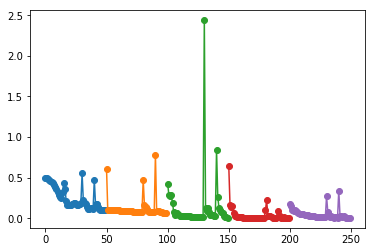

In [16]:
rng = [range(i * len(p), (i+1) * len(p)) for i, p in enumerate(repeat_losses[0])]

flatted_loss = [np.array(person).flatten().tolist() for person in repeat_losses[0]]

for i, (p, r) in enumerate(zip(flatted_loss, rng)):
    plt.plot(r, p, '-o')
    if i > 3:
        break

## Using Lasso regression to regress each athlete's testosterone with lagg 1

In [17]:
def display_alphaCV(model):
    # Display results
    m_log_alphas = -np.log10(model.alphas_)

    plt.figure(figsize=(10,10))
    ymin, ymax = 2300, 3800
    plt.plot(m_log_alphas, model.mse_path_, ':')
    plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

    plt.legend()

    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error on each fold: coordinate descent ')
    plt.axis('tight')

In [18]:
def get_regression_model(data):
    
    cv = TimeSeriesSplit(n_splits=2).split(train)
    
    model = LassoCV(cv=cv)
    
    return model

In [19]:
def fit_regression_model(model, train):
    X_train = train[:, 0:-1].reshape(-1, train.shape[1]-1) ## TODO train.shape[1] by considering the fact that the last columns is target?
    y_train = train[:, -1]
    
    model.fit(X_train, y_train)
    
    return model

In [20]:
repeats = 1
repeat_predictions = []
repeat_targetvalues = []
for r in tqdm_notebook(range(repeats), desc="Repeat"):
    
    persons_predictions = []
    persons_targetvalues = []
    
    for person in tqdm_notebook(prepared_data, desc="Athlete"):
        train, test = train_test_split(person, test_size=.33, shuffle=False)
        
        model = get_regression_model(train)
        model = fit_regression_model(model, train)
            
        predictions = list()
        for i in range(len(test)):
            # update model
            if i > 0:
                model = get_regression_model(updated_train)
                model = fit_regression_model(model, updated_train)
            yhat = model.predict(test[i,0:-1].reshape(-1, test.shape[1] -1))
            X_test = test[i, 0:-1]
            predictions.append(yhat[0])
            updated_train = np.concatenate((train, test[i,:].reshape(1, -1)))
            
        persons_predictions.append(predictions)
        persons_targetvalues.append(test[:, -1].tolist())

    repeat_predictions.append(persons_predictions)
    repeat_targetvalues.append(persons_targetvalues)

A Jupyter Widget

A Jupyter Widget

In [21]:
padded_predictions = np.array([pad_sequences(persons_predictions , dtype=np.float32, value=np.nan) for persons_predictions in repeat_predictions])
padded_targetvalues = np.array([pad_sequences(persons_targetvalues , dtype=np.float32) for persons_targetvalues in repeat_targetvalues])

(array([41., 16.,  6.,  3.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.18566106,  2.6381189 ,  5.09057673,  7.54303457,  9.9954924 ,
        12.44795024, 14.90040807, 17.35286591, 19.80532374, 22.25778158,
        24.71023941]),
 <a list of 10 Patch objects>)

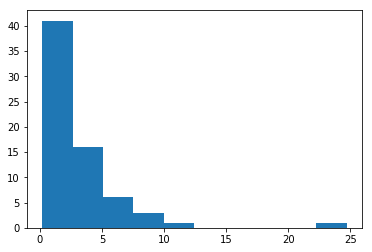

In [22]:
plt.hist(results.flatten())

/home/iss/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:412: RuntimeWarning:

invalid value encountered in sqrt

/home/iss/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



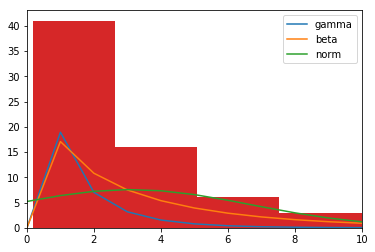

In [23]:
import scipy
import scipy.stats

dist_names = ['gamma', 'beta', 'norm']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(results.flatten())
    pdf_fitted = dist.pdf(np.arange(len(results[0])), *param[:-2], loc=param[-2], scale=param[-1]) * len(results[0])
    plt.plot(pdf_fitted, label=dist_name)

plt.legend(loc='upper right')
plt.hist(results.flatten())
plt.xlim([0,10])
plt.show()

In [24]:
results = np.nanmean((padded_targetvalues - padded_predictions)**2, axis=2) ** .5

# visulizing the results of repeated cross-validation RMSE for each person via a boxplot
df = DataFrame(results)
plotData = [] 
# for col in df.columns:
#     plotData.append(go.Box(y= df[col], name=col, showlegend=False)) 
plotData.append(go.Scatter(x= df.columns, y=df.mean(), mode='lines', name='mean'))

layout = dict(title = 'Distribution of cross-validation RMSE for each athlete',
              xaxis = dict(title = 'Athletes'),
              yaxis = dict(title = 'RMSE'))

iplot(dict(data=plotData, layout=layout))

In [25]:
# calculating a metric which in some way gives a sense of error in predictions
# the RMSEs are summarized by calculating the mean squared of all repeats for all athletes
error = np.sqrt(np.mean(np.square(np.mean(results, axis=0))))
print("Total Mean Squared Error:", error)

DataFrame(np.mean(results, axis=0)).describe()

Total Mean Squared Error: 2.582557


,0
count,68.000000
mean,1.763910
std,1.900350
min,0.126991
25%,0.577003
50%,1.108276
75%,2.461346
max,11.169332


In [26]:
show_testosterone(54)